In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
sys.path.append('/dfs/user/yhr/Perturbseq_GI/')
from maxide import Maxide

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
class GI_expt():
    # TODO get rid of hold out genes
    def __init__(self, raw=False, pick_genes = None):
        # sample: matrix sampling percentage
        # seed: sampling seed,
        # sampled_data: sampled indices from upper traingle matrix
        # test: matrix values to be predicted
        # train: observed matrix values used for training, 
        # delta: deviation from expectation as inferred using 
        #        a regression model trained on sampled_data (corresponds to sampled_data)
        # delta_tot: delta values computed for all matrix values
        # y_tot: Full true matrix (raw fitness values)
        # raws: Sampled raw fitness values (corresponds to sampled_data)
        # transformer: regression model used to determine expected fitness values
        

        with open('GI_data.pkl', 'rb') as f:
            self.data = pickle.load(f)
        self.raw = raw
        self.pick_genes = pick_genes

    def pre_process(self, sample, seed):
        itr_data = {}
        itr_data['sample'] = sample
        itr_data['seed'] = seed

        # Randomly sample from the fitness matrix
        if self.pick_genes is None:
            itr_data['sampled_data'] = \
               upper_triangle(self.data['good_phen'], k=0).sample(
               frac=float(sample) / 100., replace=False, random_state=seed).index
        else:
            itr_data['sampled_data'] = \
                upper_triangle(self.data['good_phen'].iloc[self.pick_genes,
                                                    self.pick_genes]).index

        # Set up masked delta matrix for performing matrix completion
        itr_data['delta'], itr_data['test'], \
        itr_data['train'], itr_data['delta_tot'], \
        itr_data['X_tot'], itr_data['y_tot'], itr_data['transformer'], \
        itr_data['raws'] = \
            get_masked_delta_matrix(self.data['good_phen'],
                                    itr_data['sampled_data'],
                                    self.data['fitness_mapper_gene'],
                                    self.data['good_genes'])

        return itr_data
    
    def maxide_predict(self, itr_data, maxide_delta=5e-4,
                       maxide_max_iter=5000, side=True, raw=False):
        if side:
            print('Maxide with side features')
            feats = self.data['side']
        else:
            print('Maxide with no side features')
            feats = np.identity(self.data['side'].shape[1])
            
        if raw:
            train_data = itr_data['raws']
        else:
            train_data = itr_data['delta']

        delta_pred, Z = Maxide(itr_data['delta'].values,
                                   np.flatnonzero(
                                   train_data.values.flatten()),
                                   feats,
                                   feats,
                                   delta=maxide_delta,
                                   max_iter=maxide_max_iter)

        delta_pred = pd.DataFrame(delta_pred,
                                  index=self.data['good_phen'].index,
                                  columns=self.data['good_phen'].columns)
        return delta_pred


def get_masked_delta_matrix(data, sampling, phen_mapper, good_genes):
    masked_data, mask = get_masked_data(data, sampling)

    upper_masked_data = upper_triangle(masked_data)
    predicted = upper_masked_data[upper_masked_data == 0].index
    given = upper_masked_data[upper_masked_data != 0].index

    delta_tot, X, X_tot, y, y_tot, transformer, raws = get_deltas(data, masked_data, phen_mapper, good_genes)
    delta, _ = get_masked_data(delta_tot, sampling)
    raws, _ = get_masked_data(raws, sampling)

    return delta, predicted, given, delta_tot, X_tot, y_tot, transformer, raws

def get_deltas(source_data, sampled_data, phen_mapper, good_genes):
    # this is the routine that fits a quadratic model to observed fitness measurements and returns
    # the deviations from the expectation given by that model (the "deltas")
    y = sampled_data.stack()
    y = y[y != 0]

    X = np.concatenate([y.index.get_level_values(0).map(lambda x: phen_mapper[x]).values[:, np.newaxis],
                        y.index.get_level_values(1).map(lambda x: phen_mapper[x]).values[:, np.newaxis]], axis=1)

    y_tot = source_data.loc[good_genes, good_genes].stack()
    X_tot = np.concatenate([y_tot.index.get_level_values(0).map(lambda x: phen_mapper[x]).values[:, np.newaxis],
                            y_tot.index.get_level_values(1).map(lambda x: phen_mapper[x]).values[:, np.newaxis]],
                           axis=1)

    transformer = PolynomialFeatures()
    model = make_pipeline(PolynomialFeatures(), LinearRegression())
    model.fit(X, y)

    delta = pd.Series(y_tot - model.predict(X_tot), index=y_tot.index)
    raws = pd.Series(y_tot, index=y_tot.index).unstack()
    delta = delta.unstack()

    return delta, X, X_tot, y, y_tot, model, raws


def get_deltas_unmasked(source_data, phen_mapper, good_genes):
    y_tot = source_data.loc[good_genes, good_genes].stack()
    X_tot = np.concatenate([y_tot.index.get_level_values(0).map(lambda x: phen_mapper[x]).values[:, np.newaxis],
                            y_tot.index.get_level_values(1).map(lambda x: phen_mapper[x]).values[:, np.newaxis]],
                           axis=1)

    transformer = PolynomialFeatures()
    model = make_pipeline(PolynomialFeatures(), LinearRegression())
    model.fit(X_tot, y_tot)

    delta = pd.Series(y_tot - model.predict(X_tot), index=y_tot.index)
    delta = delta.unstack()
    
    return delta


def upper_triangle(M, k=1):
    """ Copyright (C) 2019  Thomas Norman
    Return the upper triangular part of a matrix in stacked format (i.e. as a vector)
    """
    keep = np.triu(np.ones(M.shape), k=k).astype('bool').reshape(M.size)
    return M.stack(dropna=False).loc[keep]

def get_masked_data(df, ind, mean_normalize=False):
    masked_data = df.copy().values
    mask = pd.DataFrame(0, index=df.index, columns=df.columns)

    for gene1, gene2 in ind:
        mask.loc[gene1, gene2] = 1

        # assume DataFrame is symmetric
    mask = mask + mask.T
    mask = (mask != 0).values
    masked_data[~mask] = 0
    masked_data_df = pd.DataFrame(masked_data, index=df.index, columns=df.columns)

    # whether to center the observed entries such that the overall mean is 0
    if mean_normalize:
        masked_data_df = masked_data_df.stack()
        offset = masked_data_df[masked_data_df != 0]
        offset = offset.mean()
        masked_data_df[masked_data_df != 0] = masked_data_df[masked_data_df != 0] - offset
        print(offset)
        masked_data_df = masked_data_df.unstack()

    return masked_data_df, mask

In [3]:
def get_outlier_idx(arr, sd_thresh=2):
    sd = np.std(arr)
    upper = np.mean(arr)+sd_thresh*sd
    lower = np.mean(arr)-sd_thresh*sd
    return [it for it, t in enumerate(arr) if (t<lower) or (t>upper)]

def get_recall(true, pred):
    recall = len(set(get_outlier_idx(true)).intersection(set(get_outlier_idx(pred))))/\
    len(get_outlier_idx(true))
    return recall

### Set up 2 additional datasets

In [5]:
def create_GI_data_file(GI_df):

    gene_list = set(GI_df['Gene1'].values).intersection(set(GI_df['Gene2'].values))
    good_phen = pd.DataFrame(index=gene_list, columns=gene_list)
    fitness_mapper_gene = {}

    for row in GI_df.iterrows():
        good_phen.at[row[1]['Gene1'], row[1]['Gene2']] = row[1]['phen_score']
        good_phen.at[row[1]['Gene2'], row[1]['Gene1']] = row[1]['phen_score']
        fitness_mapper_gene[row[1]['Gene1']+'_'+row[1]['Gene2']] = row[1]['phen_score']

    new_GI_data['good_phen'] = good_phen
    new_GI_data['good_emap'] = None
    new_GI_data['Z-phen'] = None
    new_GI_data['Z_emap'] = None
    new_GI_data['side'] = None
    new_GI_data['fitness_mapper_gene'] = None
    new_GI_data['good_perturbations'] = None
    new_GI_data['fitness_mapper_gene'] = fitness_mapper_gene
    new_GI_data['good_genes'] = gene_list
    
    return new_GI_data

In [6]:
with open('/dfs/project/perturb-gnn/datasets/Norman2019/GI_data.pkl', 'rb') as f:
    read_file = pickle.load(f)

In [8]:
import scanpy as sc
norman_adata = sc.read_h5ad('/dfs/project/perturb-gnn/datasets/Norman2019/Norman2019_hi_umi+hvg.h5ad')

In [9]:
def get_reverse(pert):
    return pert.split('+')[-1]+'+'+pert.split('+')[0]

def check_seen(pert):
    pert_list = list(norman_adata.obs['condition'].unique())
    if pert in pert_list:
        return True
    elif get_reverse(pert) in pert_list:
        return True
    return False

def get_reverse_perts(perts):
    return [t.split('+')[-1]+'+'+t.split('+')[0] for t in perts]

def remove_reverse(perts):
    return list(set(perts).difference(set(get_reverse_perts(perts))))

def remove_duplicates_list(list_):
    import itertools
    list_.sort()
    return list(k for k,_ in itertools.groupby(list_))

### Read in cell fitness data

In [4]:
# Run prediction
GI = GI_expt(pick_genes=None)

itr_data = GI.pre_process(sample=25, seed=1)

In [88]:
# True delta 
true_deltas = get_deltas_unmasked(GI.data['good_phen'], GI.data['fitness_mapper_gene'], GI.data['good_genes'])

map_dict = {c:c for c in true_deltas.columns}
map_dict['CBARP']='C19orf26'
map_dict['C19orf26']='C19orf26'
map_dict['FOXL2NB']='C3orf72'
map_dict['RP5-862P8.2']='KIAA1804'
map_dict['RHOXF2B']='RHOXF2BB'
map_dict['C3orf72'] = 'C3orf72'
map_dict['RHOXF2BB'] = 'RHOXF2BB'

### Read in GEARS predicted GIs

In [89]:
#all_GIs = np.load('/dfs/user/yhr/snap/perturb_GNN/pertnet_umi_no_test_jfix_allGI.npy', allow_pickle=True).item()

all_GIs = np.load('/dfs/user/yhr/gears2/Evaluation/gears_misc_umi_no_test_allGI.npy', allow_pickle=True).item()
#all_GIs = np.load('/dfs/user/yhr/gears2/Evaluation/gears_misc_positional_umi_no_test_allGI.npy', allow_pickle=True).item()


heatmaps = {}
for metric in ['mag', 'dcor', 'corr_fit', 'dominance', 'eq_contr']:
    heatmaps[metric] = pd.DataFrame(columns=GI.data['good_genes'], 
                                    index=GI.data['good_genes'])
    for g1 in GI.data['good_genes']:
        for g2 in GI.data['good_genes']:
            if g1 != g2:
                try:
                    if g1 in map_dict:
                        g1 = map_dict[g1]
                    elif g2 in map_dict:
                        g2 = map_dict[g2]
                    try:
                        pert = str([g1, g2])
                        z = all_GIs[pert][metric]
                    except:
                        pert = str([g2, g1])
                        z = all_GIs[pert][metric]
                    heatmaps[metric].at[g1,g2] = z
                    heatmaps[metric].at[g2,g1] = z
                except:
                    continue

heatmaps['mag'] = heatmaps['mag'].fillna(1)
heatmaps['dcor'] = heatmaps['dcor'].fillna(0)
heatmaps['dominance'] = heatmaps['dominance'].fillna(0)
heatmaps['corr_fit'] = heatmaps['corr_fit'].fillna(2)
heatmaps['eq_contr'] = heatmaps['eq_contr'].fillna(2)

In [91]:
true_deltas.columns = true_deltas.columns.map(map_dict)
true_deltas.index = true_deltas.index.map(map_dict)

heatmaps['mag'].columns = heatmaps['mag'].columns.map(map_dict)
heatmaps['mag'].index = heatmaps['mag'].index.map(map_dict)

heatmaps['corr_fit'].columns = heatmaps['corr_fit'].columns.map(map_dict)
heatmaps['corr_fit'].index = heatmaps['corr_fit'].index.map(map_dict)

In [92]:
genes_of_interest = heatmaps['mag'].columns

all_possible_combos = []
for g1 in genes_of_interest:
    for g2 in genes_of_interest:
        if g1==g2:
            continue
        all_possible_combos.append(sorted([g1,g2]))
        
all_possible_combos = remove_duplicates_list(all_possible_combos)
all_combos_idx = pd.MultiIndex.from_tuples(all_possible_combos, names=['Gene1', 'Gene2'])

In [93]:
shared_index_test = [x for x in all_combos_idx if not check_seen('+'.join(x))]
shared_index_train = [x for x in all_combos_idx if check_seen('+'.join(x))]

### Use correct set of genes and align cell fitness predictions and GEARS predictions

In [15]:
import sys
sys.path.append('../../gears_misc/')

from gears import PertData, GEARS

In [16]:
pert_data = PertData('/dfs/project/perturb-gnn/datasets/data')
pert_data.load(data_path = '/dfs/project/perturb-gnn/datasets/data/norman_umi/')
pert_data.prepare_split(split = 'no_test', seed = 1)
pert_data.get_dataloader(batch_size = 32, test_batch_size = 128)

gears_model = GEARS(pert_data, device = 'cpu', 
                    weight_bias_track = False, 
                    proj_name = 'experiment_GI', 
                    exp_name = 'experiment_GI')
gears_model.model_initialize()

Found local copy...
These perturbations are not in the GO graph and is thus not able to make prediction for...
['RHOXF2BB+ctrl' 'LYL1+IER5L' 'ctrl+IER5L' 'KIAA1804+ctrl' 'IER5L+ctrl'
 'RHOXF2BB+ZBTB25' 'RHOXF2BB+SET']
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Done!


In [17]:
exp_df = gears_model.adata.to_df()
exp_df['condition'] = gears_model.adata.obs['condition']
mean_exp_df = exp_df.groupby('condition').mean()

In [18]:
for pert_id, expression in mean_exp_df.iterrows():
    if 'ctrl' in pert_id:
        pert_name = pert_id.strip('+ctrl')
    else:
        pert_name = '_'.join(pert_id.split('+'))
    gears_model.saved_pred[pert_name] = expression.values

In [25]:
combo_names = [n for n in list(gears_model.saved_pred.keys()) if '_' in n]

true_mags = {}
true_corr_fit = {}
for itr, combo in enumerate(combo_names):
    print(itr, combo)
    res = gears_model.GI_predict(combo.split('_'))
    true_mags[combo]=res['mag']
    true_corr_fit[combo]=res['corr_fit']

0 AHR_FEV
1 AHR_KLF1
2 BCL2L11_BAK1
3 BCL2L11_TGFBR2
4 BPGM_SAMD1
5 BPGM_ZBTB1
6 C3orf72_FOXL2
7 CBL_CNN1
8 CBL_PTPN9
9 CBL_PTPN12
10 CBL_TGFBR2
11 CBL_UBASH3A
12 CBL_UBASH3B
13 CDKN1B_CDKN1A
14 CDKN1C_CDKN1A
15 CDKN1C_CDKN1B
16 CEBPB_CEBPA
17 CEBPB_MAPK1
18 CEBPB_OSR2
19 CEBPB_PTPN12
20 CEBPE_CEBPA
21 CEBPE_CEBPB
22 CEBPE_CNN1
23 CEBPE_KLF1
24 CEBPE_PTPN12
25 CEBPE_RUNX1T1
26 CEBPE_SPI1
27 CNN1_MAPK1
28 CNN1_UBASH3A
29 DUSP9_ETS2
30 DUSP9_IGDCC3
31 DUSP9_KLF1
32 DUSP9_MAPK1
33 DUSP9_PRTG
34 DUSP9_SNAI1
35 ETS2_CEBPE
36 ETS2_CNN1
37 ETS2_IGDCC3
38 ETS2_IKZF3
39 ETS2_MAP7D1
40 ETS2_MAPK1
41 ETS2_PRTG
42 FEV_CBFA2T3
43 FEV_ISL2
44 FEV_MAP7D1
45 FOSB_CEBPB
46 FOSB_CEBPE
47 FOSB_IKZF3
48 FOSB_OSR2
49 FOSB_PTPN12
50 FOSB_UBASH3B
51 FOXA1_FOXF1
52 FOXA1_FOXL2
53 FOXA1_HOXB9
54 FOXA3_FOXA1
55 FOXA3_FOXF1
56 FOXA3_FOXL2
57 FOXA3_HOXB9
58 FOXF1_FOXL2
59 FOXF1_HOXB9
60 FOXL2_HOXB9
61 FOXL2_MEIS1
62 IGDCC3_MAPK1
63 IGDCC3_PRTG
64 IGDCC3_ZBTB25
65 IRF1_SET
66 JUN_CEBPA
67 JUN_CEBPB
68 KIF18B_KIF2C

In [26]:
#np.save('true_mags', true_mags)
#np.save('true_corr_fit', true_corr_fit)

In [301]:
shared_mags_train = []
shared_corr_fits_train = []
shared_index_train_true = []
for g1, g2 in shared_index_train:
    try:
        shared_mags_train.append(true_mags[map_dict[g1]+'_'+map_dict[g2]])
        shared_corr_fits_train.append(true_corr_fit[map_dict[g1]+'_'+map_dict[g2]])
        shared_index_train_true.append((g1,g2))
    except:
        try:
            shared_mags_train.append(true_mags[map_dict[g2]+'_'+map_dict[g1]])
            shared_corr_fits_train.append(true_corr_fit[map_dict[g2]+'_'+map_dict[g1]])
            shared_index_train_true.append((g2,g1))
        except:
            print(g1,g2)
            continue
            
shared_index_train_true = pd.MultiIndex.from_tuples(shared_index_train_true, names=['Gene1', 'Gene2'])

IER5L LYL1
RHOXF2BB SET
RHOXF2BB ZBTB25


### Identify strong interactions using delta (cell fitness) values

In [60]:
GI.data['good_emap'].columns = GI.data['good_emap'].columns.map(map_dict)
GI.data['good_emap'].index = GI.data['good_emap'].index.map(map_dict)

In [197]:
import matplotlib.pyplot as plt
import matplotlib

In [198]:
font = {'family' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

Text(0.5, 0, 'Cell fitness-derived interaction (GI) score')

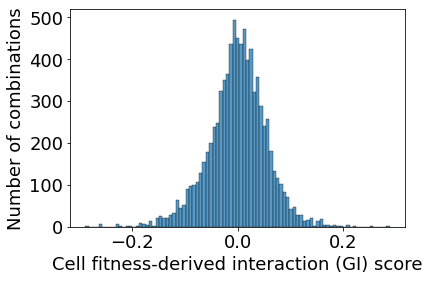

In [200]:
sns.histplot(true_deltas.stack().values)
plt.ylabel('Number of combinations')
plt.xlabel('Cell fitness-derived interaction (GI) score')

In [446]:
shared_mags = heatmaps['mag'].stack()[shared_index_test]
shared_fitness = true_deltas.stack()[shared_index_test]
shared_raw_fitness = GI.data['good_emap'].stack()[shared_index_test]

#shared_mags_train = heatmaps['mag'].stack()[shared_index_train]
shared_fitness_train = true_deltas.stack()[shared_index_train_true]
shared_raw_fitness_train = GI.data['good_emap'].stack()[shared_index_train_true]

lower_bound = -2*np.std(true_deltas.stack())
upper_bound = +2*np.std(true_deltas.stack())

additive_lbound = -1*np.std(true_deltas.stack())
additive_ubound = +1*np.std(true_deltas.stack())

non_additive_recall = shared_fitness[np.logical_or(shared_fitness<lower_bound, 
                                            shared_fitness>upper_bound)].index

In [447]:
shared_mags_df = pd.DataFrame(shared_mags)
shared_mags_df = shared_mags_df.rename(columns = {0:'GEARS'})
shared_mags_df['pert'] = ['_'.join(x) for x in shared_mags_df.index]

shared_fitness_df = pd.DataFrame(shared_fitness)
shared_fitness_df = shared_fitness_df.rename(columns = {0:'Delta'})
shared_fitness_df['pert'] = ['_'.join(x) for x in shared_fitness_df.index]

shared_df = shared_mags_df.merge(shared_fitness_df, on='pert')
shared_df = shared_df.set_index('pert')

In [448]:
shared_mags_df_train = pd.DataFrame(shared_mags_train)
shared_mags_df_train = shared_mags_df_train.rename(columns = {0:'GEARS'})
shared_mags_df_train.index = shared_index_train_true
shared_mags_df_train['pert'] = ['_'.join(x) for x in shared_mags_df_train.index]

shared_fitness_df_train = pd.DataFrame(shared_fitness_train)
shared_fitness_df_train = shared_fitness_df_train.rename(columns = {0:'Delta'})
shared_fitness_df_train.index = shared_index_train_true
shared_fitness_df_train['pert'] = ['_'.join(x) for x in shared_fitness_df_train.index]

shared_df_train = shared_mags_df_train.merge(shared_fitness_df_train, on='pert')
shared_df_train = shared_df_train.set_index('pert')

In [449]:
shared_df['GEARS_corrected'] = shared_df['GEARS']-np.mean(shared_df['GEARS'])
shared_df_train['GEARS_corrected'] = shared_df_train['GEARS']-np.mean(shared_df_train['GEARS'])

#znorm
shared_df['GEARS_znorm'] = (shared_df['GEARS']-np.mean(shared_df['GEARS']))/np.std(shared_df['GEARS'])
shared_df_train['GEARS_znorm'] = (shared_df_train['GEARS']-np.mean(shared_df_train['GEARS']))/np.std(shared_df_train['GEARS'])

#znorm
shared_df['GEARS_znorm_1'] = (shared_df['GEARS']-1)/np.std(shared_df['GEARS'])
shared_df_train['GEARS_znorm_1'] = (shared_df_train['GEARS']-1)/np.std(shared_df_train['GEARS'])


# max_min_norm
shared_df['GEARS_mm_norm'] = (shared_df['GEARS'])/np.max(shared_df['GEARS'])
shared_df_train['GEARS_mm_norm'] = (shared_df_train['GEARS'])/np.max(shared_df_train['GEARS'])



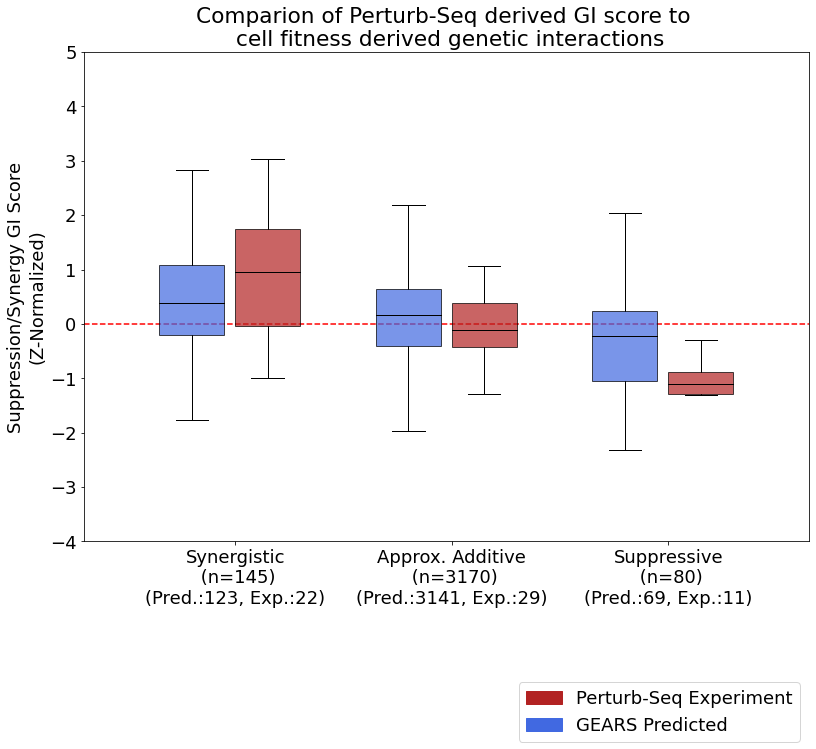

In [458]:
import matplotlib.patches as mpatches

additive_idx = np.logical_and(shared_df['Delta']<additive_ubound, shared_df['Delta']>additive_lbound)
additive_idx_train = np.logical_and(shared_df_train['Delta']<additive_ubound, shared_df_train['Delta']>additive_lbound)


plt.figure(figsize=[13,9])
_ = plt.boxplot([shared_df[shared_df['Delta']<lower_bound]['GEARS_znorm'],
                 shared_df[additive_idx]['GEARS_znorm'],
                 shared_df[shared_df['Delta']>upper_bound]['GEARS_znorm']], 
             patch_artist=True, 
             boxprops=dict(facecolor='royalblue', color='black', alpha=0.7, edgecolor='black'), 
                medianprops=dict(color='black'),
                showfliers=False)

_ = plt.boxplot([shared_df_train[shared_df_train['Delta']<lower_bound]['GEARS_znorm'],
              shared_df_train[additive_idx_train]['GEARS_znorm'],
              shared_df_train[shared_df_train['Delta']>upper_bound]['GEARS_znorm']], patch_artist=True, 
             boxprops=dict(facecolor='firebrick', color='black', alpha=0.7), 
             medianprops=dict(color='black'),
             positions=[1.35, 2.35, 3.35], showfliers=False)

plt.axhline(y=0.00, color='r', linestyle='--')

red_patch = mpatches.Patch(color='firebrick', label='Perturb-Seq Experiment')
blue_patch = mpatches.Patch(color='royalblue', label='GEARS Predicted')

plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=[1.0,-0.27])

_ = plt.xticks([1.2,2.2,3.2])
ax = plt.gca()
_ = ax.set_xticklabels(['Synergistic\n (n=145)\n(Pred.:123, Exp.:22)', 
                    'Approx. Additive\n (n=3170)\n(Pred.:3141, Exp.:29)',
                    'Suppressive\n (n=80)\n(Pred.:69, Exp.:11)', ])

plt.title('Comparion of Perturb-Seq derived GI score to \n cell fitness derived genetic interactions')

plt.ylim([-4,5])
plt.ylabel('Suppression/Synergy GI Score\n(Z-Normalized)')

plt.savefig('GI_map_valid.pdf')

### Significance testing

In [436]:
from scipy.stats import ttest_ind

In [441]:
ttest_ind(shared_df[shared_df['Delta']>upper_bound]['GEARS'], 
          shared_df[additive_idx]['GEARS'], alternative='less')

Ttest_indResult(statistic=-3.014218789789321, pvalue=0.0012982906084156142)

In [442]:
ttest_ind(shared_df_train[shared_df_train['Delta']>upper_bound]['GEARS'], 
          shared_df_train[additive_idx_train]['GEARS'], alternative='less')

Ttest_indResult(statistic=-5.426436643479988, pvalue=1.7407880781066987e-06)

In [443]:
ttest_ind(shared_df[shared_df['Delta']<lower_bound]['GEARS'], 
          shared_df[additive_idx]['GEARS'], alternative='greater')

Ttest_indResult(statistic=3.9254593097028674, pvalue=4.4176312024182606e-05)

In [445]:
ttest_ind(shared_df_train[shared_df_train['Delta']<lower_bound]['GEARS'], 
          shared_df_train[additive_idx_train]['GEARS'], alternative='greater')

Ttest_indResult(statistic=4.17862972478509, pvalue=6.017577480926996e-05)

### Accuracy

In [424]:
sum(shared_df[shared_df['Delta']>upper_bound]['GEARS_znorm']<0)/len(shared_df[shared_df['Delta']>upper_bound])

0.5942028985507246

In [425]:
sum(shared_df_train[shared_df_train['Delta']>upper_bound]['GEARS_znorm']<0)/len(shared_df_train[shared_df_train['Delta']>upper_bound])

1.0

In [420]:
sum(shared_df_train[shared_df_train['Delta']<lower_bound]['GEARS_znorm']>0)/len(shared_df_train[shared_df_train['Delta']<lower_bound])


0.6818181818181818

### Fig 5d selecting perturbations

In [405]:
np.percentile(true_deltas.stack().values, 97)

0.09882337778445384

In [401]:
g1='LYL1'
g2='CEBPE'

print(heatmaps['corr_fit'].loc[g1, g2])
print(heatmaps['mag'].loc[g1, g2])

0.8547796694799731
0.529502927092253


In [387]:
g1='LYL1'
g2='OSR2'

print(heatmaps['corr_fit'].loc[g1, g2])
print(heatmaps['mag'].loc[g1, g2])

0.690086895287108
0.5160769168201739


In [392]:
true_deltas.loc['LYL1', 'OSR2']

0.09944228104835559

In [394]:
true_deltas.loc['LYL1', 'CEBPE']

0.10415258263788907